In [ ]:
#import some necessary librairies

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew


Importing data from Kaggle

In [ ]:
#! pip install -q kaggle

#from google.colab import files

#files.upload()

In [ ]:
#! mkdir ~/.kaggle

#! cp kaggle.json ~/.kaggle/

#! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle competitions download -c house-prices-advanced-regression-techniques

Importing the train and test datasets and putting them in pandas dataframe.

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


The ID feature is useless, so let's drop it, but save the columns.

In [ ]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print("Train data size: {} ".format(train.shape)) 
print("Test data size: {} ".format(test.shape))

Train data size: (1460, 80) 
Test data size: (1459, 79) 


Let us take a look at the variable we need to analyze, SalePrice. 


 mu = 180921.20 and sigma = 79415.29



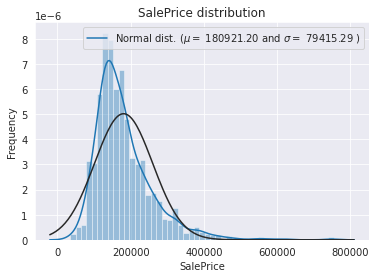

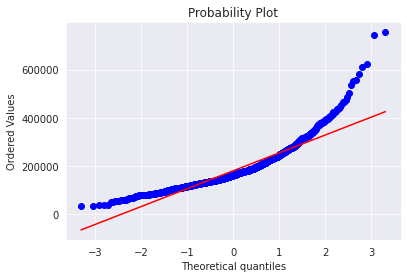

In [ ]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

This variable is not normally distributed. It is good to log transform it to a normal distribution, which is better handled by regression models. 


 mu = 12.02 and sigma = 0.40



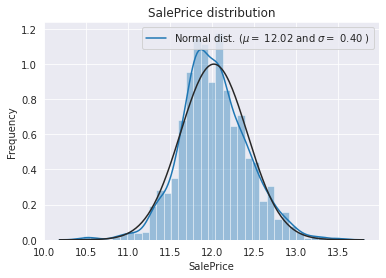

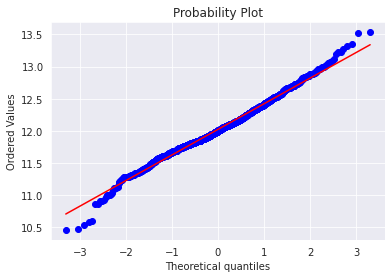

In [ ]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

##Features Engineering


Now let's look for missing values in the train and test datasets. First, we will concatenate both 

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


Then, let's take a look at the missing values:

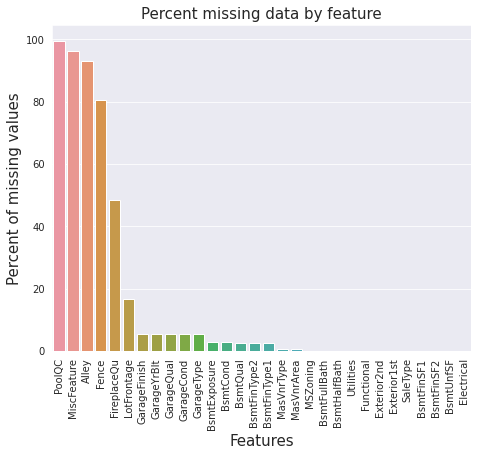

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

f, ax = plt.subplots(figsize=(7.5, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

We can see that some features have a high number of missing values.

Let's take a loot at those which have more than 50% of missing values.

In [ ]:
all_data[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']].head()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,TA
2,NaN,NaN,NaN,NaN,TA
3,NaN,NaN,NaN,NaN,Gd
4,NaN,NaN,NaN,NaN,TA


The data description says that "NaN" means that the house does not have that feature (Pool, alley access, fences, fireplaces or misc features). Therefore, we must replace it with "None".  

In [ ]:
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"):
    all_data[col] = all_data[col].fillna("None")

The same goes for the features 'GarageType', 'GarageFinish', 'GarageQual' and 'GarageCond': 

In [ ]:
all_data[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].head()

,GarageType,GarageFinish,GarageQual,GarageCond
0,Attchd,RFn,TA,TA
1,Attchd,RFn,TA,TA
2,Attchd,RFn,TA,TA
3,Detchd,Unf,TA,TA
4,Attchd,RFn,TA,TA


In [ ]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna("None")

The missing data in the features 'GarageYrBlt', 'GarageArea' and 'GarageCars' will be replaced by 0, since no garage means no year of building, no area and no car.

In [ ]:
all_data[['GarageYrBlt', 'GarageArea', 'GarageCars']].head()

,GarageYrBlt,GarageArea,GarageCars
0,2003.0,548.0,2.0
1,1976.0,460.0,2.0
2,2001.0,608.0,2.0
3,1998.0,642.0,3.0
4,2000.0,836.0,3.0


In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

The same goes for BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath: all these features are related to the existence of a basement in the house, and 'Nan' means there is no basement.

In [ ]:
all_data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,706.0,0.0,150.0,856.0,1.0,0.0
1,978.0,0.0,284.0,1262.0,0.0,1.0
2,486.0,0.0,434.0,920.0,1.0,0.0
3,216.0,0.0,540.0,756.0,1.0,0.0
4,655.0,0.0,490.0,1145.0,1.0,0.0


In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

For the features 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', NaN means no basement, so we substitute with "None".

In [ ]:
all_data[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,Gd,TA,No,GLQ,Unf
1,Gd,TA,Gd,ALQ,Unf
2,Gd,TA,Mn,GLQ,Unf
3,TA,Gd,No,ALQ,Unf
4,Gd,TA,Av,GLQ,Unf


In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

For "MasVnrType" and "MasVnrArea", 'NaN' probably means no masonry veneer in the house. Thus, we can fill 0 for the area and 'None' for the type.

In [ ]:
all_data[['MasVnrType','MasVnrArea']].head()

,MasVnrType,MasVnrArea
0,BrkFace,196.0
1,None,0.0
2,BrkFace,162.0
3,None,0.0
4,BrkFace,350.0


In [ ]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

The feature 'MSZoning' means the general zoning classification. It is not very clear if we should handle the missing values in this case. As there are few missing values, it's a good guess to substitute them with the most common value, 'RL'.

In [ ]:
all_data[['MSZoning']].describe()

,MSZoning
count,2915
unique,5
top,RL
freq,2265


In [ ]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

That same argument goes for the features 'Electrical', 'KitchenQuale', 'Exterior1st', 'Exterior2nd', 'SaleType'.

In [ ]:
all_data[['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']].describe()

,Electrical,KitchenQual,Exterior1st,Exterior2nd,SaleType
count,2918,2918,2918,2918,2918
unique,5,4,15,16,9
top,SBrkr,TA,VinylSd,VinylSd,WD
freq,2671,1492,1025,1014,2525


In [ ]:
for col in ('Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [ ]:
'''
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
'''

"\nall_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])\nall_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])\nall_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])\nall_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])\nall_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])\n"

All rows of the 'Utilities' feature are composed of the same values "AllPub", excepted for two missing values and one 'NoSeWa'. Therefore, this feature is not going to help training the model, so we will drop it.

In [ ]:
all_data[['Utilities']].describe()

,Utilities
count,2917
unique,2
top,AllPub
freq,2916


In [ ]:
all_data = all_data.drop(['Utilities'], axis=1)

For the 'Functional' feature, data description says "NaN" means typical.

In [ ]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

Finally, we replace the 'NaN' in 'MSSubClass' with "None"

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

 Finally, the most complex one is 'LotFrontage'. It relates to linear feet of street connected to property. Probably the best way to handle these missing values is to fill the by the median LotFrontage of the Neighborhood.
 
 
 Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood


In [ ]:
all_data[["Neighborhood"]].head()

,Neighborhood
0,CollgCr
1,Veenker
2,CollgCr
3,Crawfor
4,NoRidge


In [ ]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

Then, we check remaining missing values, if any. 

In [ ]:

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


Now we must transform some numerical values that are in fact categorical. 

In [ ]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

And finally, we get the new train and test set, with the filled missing values:

In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 338)


In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]

X_train = train.values
X_test = test.values
#y_train was already defined

##Model Building

We begin by importing the relevant modules.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb

Splitting the train data into a train and a validation set:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .3, random_state=0)

###Random Forest

In [ ]:
#model_forest = RandomForestRegressor(n_estimators=400, random_state=0)
model_forest = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

model_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
pred_forest_train = model_forest.predict(X_train)
pred_forest_val = model_forest.predict(X_val)

print('Root Mean Squared Error Train:', np.sqrt(metrics.mean_squared_error(y_train, pred_forest_train)))
print('Root Mean Squared Error Validation:', np.sqrt(metrics.mean_squared_error(y_val, pred_forest_val)))

Root Mean Squared Error Train: 0.09785843547485013
Root Mean Squared Error Validation: 0.13657893508604857


In [ ]:
predictions_forest = model_forest.predict(X_test)

###LightGBM

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_lgb.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred_lgb_train = model_lgb.predict(X_train)
pred_lgb_val = model_lgb.predict(X_val)

print('Root Mean Squared Error Train:', np.sqrt(metrics.mean_squared_error(y_train, pred_lgb_train)))
print('Root Mean Squared Error Validation:', np.sqrt(metrics.mean_squared_error(y_val, pred_lgb_val)))

Root Mean Squared Error Train: 0.06981296508960269
Root Mean Squared Error Validation: 0.12629843974063337


In [ ]:
predictions_lgb = model_lgb.predict(X_test)

##Submission:
Random Forest:

In [ ]:
sub_rf = pd.DataFrame()
sub_rf['Id'] = test_ID
#sub['SalePrice'] = predictions_forest
sub_rf["SalePrice"] = np.expm1(predictions_forest)
sub_rf.to_csv('submission_forest.csv',index=False)

LightGBM:

In [ ]:
sub_lgb = pd.DataFrame()
sub_lgb['Id'] = test_ID
#sub['SalePrice'] = predictions_forest
sub_lgb["SalePrice"] = np.expm1(predictions_lgb)
sub_lgb.to_csv('submission_lgbm.csv',index=False)

Ensemble of both models:

In [ ]:
ensemble = np.expm1(predictions_lgb)*0.5 + np.expm1(predictions_forest)*0.5

sub_ensemble = pd.DataFrame()
sub_ensemble['Id'] = test_ID
sub_ensemble["SalePrice"] = ensemble
sub_ensemble.to_csv('submission_ensemble.csv',index=False)